This notebook executes the cross-reference between the WMT 19 DARR data used in the BARTScore paper and the DA human evaluation obtained in the WMT 19 Shared Metrics task. 

As of today (2022-09-10), the notebook proceeds as follows:

1. Load BARTScore pkl data files for each of the 7 languages. 
1. Flatten these results into (doc, ref, hyp).
1. Eliminate duplicates in the flattened version (since it is a pairwise comparison, it might happen so that there are duplicate entries).
1. Average over duplicate entries in the DA dataset (We have repeated (doc, ref, hyp) triplets which were assigned different scores. This can be explained by the lack of information about the systems that generated the hyp and the fact that different systems may end up producing the same hyp.)
1. Map DA (discrete [0, 100] to the [0, 1] domain)
1. Create train/dev/test set based on the context to avoid label leakage.
1. Create datasets w/ 2 classes and 5 classes. Using equally spaced thresholds in the range of [0, 1]. 



BARTScore syntax for WMT 19 - DARR dataset: 

```python
{
    "doc_id": {
        "src": "This is the source text.",
        "ref": "This is the reference translation.",
        "better": {
            "sys_name": "System name 1",
            "sys": "This is system translation 1.",
            "scores": {} 
        },
        "worse": {
            "sys_name": "System name 2",
            "sys": "This is system translation 2.",
            "scores": {}
        }
    }
}
```

In [1]:
import pandas as pd
import numpy as np

import joblib
import os

In [2]:
def print_sep(msg):
    print("\n" * 3)
    print("=" * 80)
    print(msg)
    print("=" * 80)

### BARTScore dataset preprocessing methods

In [3]:
def flatten(dataset: dict) -> list:
    flattened = []
    
    for doc_id, doc_data in dataset.items():
        for system in ("better", "worse"):
            data = {
                "src": doc_data["src"],
                "ref": doc_data["ref"],
                "mt": doc_data[system]["sys"],
                "sys_name": doc_data[system]["sys_name"],
                # To facilitate tracing back to the BARTScore paper
                "bartscore_doc_id": doc_id,
            }
            
            flattened.append(data)
    return flattened


def load_mt(data_dir, dataset_name) -> pd.DataFrame:
    filepath = f"{data_dir}/{dataset_name}/data.pkl"
    data = joblib.load(filepath)
    print(f"Loaded {len(data)} examples for {dataset_name}.")
    
    # Transform it into long format
    data = flatten(data)
    data = pd.DataFrame(data)
    
    # Remove duplicates
    cols = data.columns[:-1]
    print(cols)
    data = data[~data[cols].duplicated()]
    print("Total length of data after removing duplicates:", len(data))

    return data

### Direct Assessment Methods

In [4]:
def load_mt_da(data_dir: str, dataset_name: str) -> pd.DataFrame:
    df_da = pd.read_csv(f"{data_dir}/2019-da.csv")
    df_da = df_da[df_da["lp"] == dataset_name]
    print("Total len of df_da:", len(df_da))

    # Average duplicate values for DA data
    duplicates_cols = ["lp", "src", "mt", "ref"]
    
    # Consider all duplicates (even first and last instances)
    duplicates_mask = df_da[duplicates_cols].duplicated(keep=False)
    duplicates = df_da[duplicates_mask].copy()
    duplicates_annotations = duplicates.groupby(duplicates_cols, as_index=False).count()["annotators"]

    duplicates = duplicates.groupby(duplicates_cols, as_index=False).mean()
    duplicates["annotators"] = duplicates_annotations

    df_da_non_dup = df_da[~duplicates_mask]
    df_da = pd.concat((df_da_non_dup, duplicates))
    print("Total length of df_da after removing duplicates:", len(df_da))
    
    return df_da

## Preprocess BARTScore datasets

Generate intermediate file with the preprocessing steps we mention before, including the duplicates handling and the scaling of the human scores. The files will be created at `"./experiments/mt_data/preprocessed/{LANGUAGE_PAIR}/data_darr_w_scores.csv"`

In [5]:
DIR_DATASET_RAW = "./experiments/mt_data/raw"
DIR_DATASET_PREPROC = "./experiments/mt_data/preproc"

PREPROC_DATA_FILENAME = "WMT19DARR_w_scores"

In [6]:
for src_lang in ("gu", "kk", "zh", "de", "fi", "lt", "ru"):
    language_pair = f"{src_lang}-en"
    output_dir = f"{DIR_DATASET_PREPROC}/{language_pair}"
    os.makedirs(output_dir, exist_ok=True)

    print_sep(language_pair)
    # -------------------------------------------------------------------------------
    # Step 1. Load and create long-format version of DARR dataset
    # -------------------------------------------------------------------------------
    df_darr = load_mt(DIR_DATASET_RAW, language_pair)
    # -------------------------------------------------------------------------------
    # Step 2. **Load DIRECT ASSESSMENT data**
    # -------------------------------------------------------------------------------
    df_da = load_mt_da(DIR_DATASET_RAW, language_pair)

    # -------------------------------------------------------------------------------
    # Step 3. Merge them based on src, ref, and mt :)
    # -------------------------------------------------------------------------------
    df_darr_w_scores = df_darr.merge(df_da, on=["src", "ref", "mt"], how="left")
    assert len(df_darr) == len(df_darr_w_scores)
    print("\nFinal length:", len(df_darr_w_scores))

    # -------------------------------------------------------------------------------
    # Step 4. Persist in intermediate file
    # -------------------------------------------------------------------------------
    out_filepath = f"{output_dir}/{PREPROC_DATA_FILENAME}.csv"
    df_darr_w_scores.to_csv(out_filepath, index=False)

    assert len(df_darr_w_scores) == len(pd.read_csv(out_filepath))





gu-en
Loaded 20110 examples for gu-en.
Index(['src', 'ref', 'mt', 'sys_name'], dtype='object')
Total length of data after removing duplicates: 9117
Total len of df_da: 9063
Total length of df_da after removing duplicates: 9063

Final length: 9117




kk-en
Loaded 9728 examples for kk-en.
Index(['src', 'ref', 'mt', 'sys_name'], dtype='object')
Total length of data after removing duplicates: 6422
Total len of df_da: 6789
Total length of df_da after removing duplicates: 6782

Final length: 6422




zh-en
Loaded 31070 examples for zh-en.
Index(['src', 'ref', 'mt', 'sys_name'], dtype='object')
Total length of data after removing duplicates: 17278
Total len of df_da: 20170
Total length of df_da after removing duplicates: 18687

Final length: 17278




de-en
Loaded 85365 examples for de-en.
Index(['src', 'ref', 'mt', 'sys_name'], dtype='object')
Total length of data after removing duplicates: 30150
Total len of df_da: 31887
Total length of df_da after removing duplicates: 25028

Final len

## TRAIN-DEV-TEST SPLIT



In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
def train_test_split_ids(ids, test_fraction, dev_fraction=None, seed=42):
    dev_ids, test_ids = [], []
    
    # Select the indices for the holdout set
    rand = np.random.default_rng(seed)
    ids = np.array(ids)
    rand.shuffle(ids)
    
    assert 0 < test_fraction <= 1, f"Invalid test_fraction: {test_fraction}"
    test_num = round(test_fraction * len(ids))
    
    test_ids = ids[:test_num]    
    print("Collecting", len(test_ids), "examples for the holdout set.")
          
    train_ids = ids[test_num:]
    if dev_fraction is not None:
        assert 0 < dev_fraction <= 1, f"Invalid dev_fraction: {dev_fraction}"
        dev_num = round(dev_fraction * len(ids))
    
        dev_ids = ids[test_num:test_num+dev_num]    
        print("Collecting", len(dev_ids), "examples for the dev set.")
    
        train_ids = ids[test_num+dev_num:]
    
    print("Collecting", len(train_ids), "examples for the training set.")
    return train_ids, dev_ids, test_ids


def assert_non_overlapping(list_ids):
    initial_set = {}

    for ss in list_ids:
        for s in ss:
            if initial_set.get(s, False):
                raise ValueError("Overlapping values")
            else:
                initial_set[s] = 1

In [9]:
def plot_distributions(data: list, labels: list, figsize=(10, 4), **kwargs):
    n = len(data)
    fig, axes = plt.subplots(1, n, sharex=True, sharey=True, tight_layout=True, figsize=figsize)

    hist_kwargs = {"bins": 10}
    hist_kwargs.update(**kwargs)
    
    for i, (datum, label) in enumerate(zip(data, labels)):
        sns.histplot(ax=axes[i], data=datum, **hist_kwargs)
        axes[i].set_title(label)
    plt.show()
    
    
def get_distribution(data, binrange, bins):
    out, bins = pd.cut(binrange, bins, retbins=True)
    
    intervals = pd.cut(data, bins=bins)
    return pd.DataFrame(intervals.value_counts() / len(data)).sort_index().reset_index()


def discretize_dist(data, col, binrange, bins):
    data = data.copy()

    out, bins = pd.cut(binrange, bins=bins, retbins=True) 
    intervals = pd.cut(data[col], bins=bins)
    data["bin"] = intervals
    data["label"] = intervals.cat.codes
    
    return data

In [10]:
DIR_DATASET_PREPROC = "./experiments/mt_data/preproc"
PREPROC_DATA_FILENAME = "WMT19DARR_w_scores"
TARGET_COL = "raw_score"

SEED = 498151
DEV_FRACTION = 0.30
TEST_FRACTION = 0.30

In [11]:
def collect_src(data: pd.DataFrame, unique_src, ids, col="src") -> pd.DataFrame:
    selected_src = unique_src[ids]
    data = data[data[col].isin(selected_src)].reset_index()
    
    return data

#### 





gu-en
Len(train): 3644  |  Len(dev): 2737  |  Len(test): 2736
Train, dev, test set `human_score` distribution


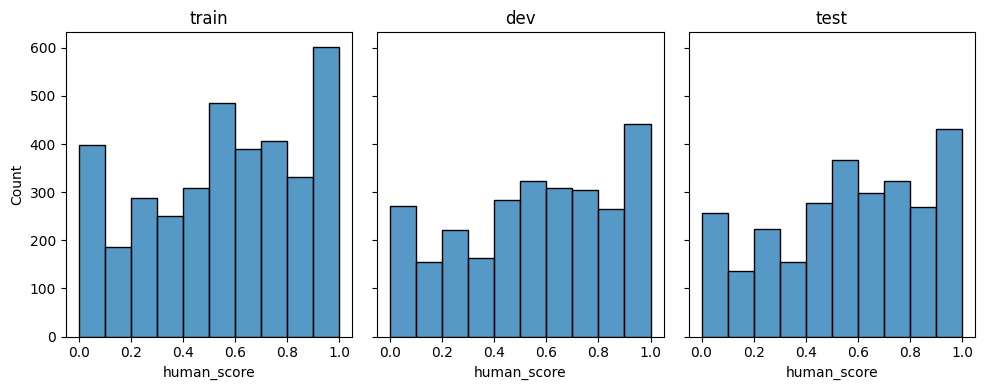

----------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
----------------------------------------------------------------------


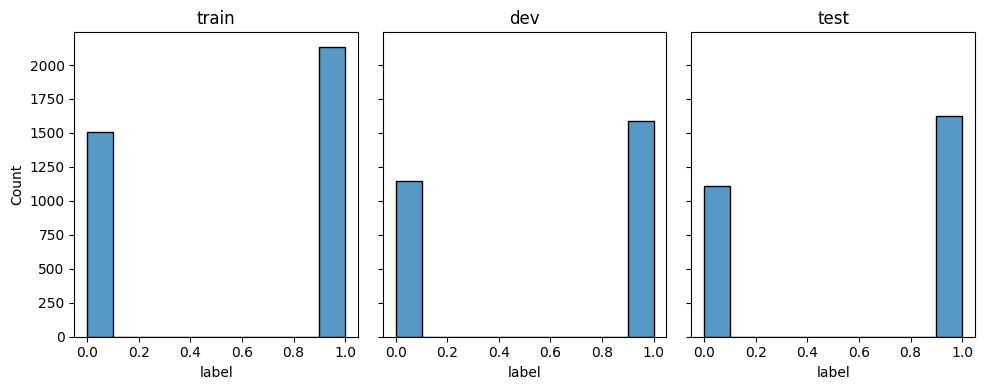

train
           index  human_score
0  (-0.001, 0.5]      0.41438
1     (0.5, 1.0]      0.58562
dev
           index  human_score
0  (-0.001, 0.5]     0.418707
1     (0.5, 1.0]     0.581293
test
           index  human_score
0  (-0.001, 0.5]     0.406433
1     (0.5, 1.0]     0.593567
all
           index  human_score
0  (-0.001, 0.5]     0.413294
1     (0.5, 1.0]     0.586706
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


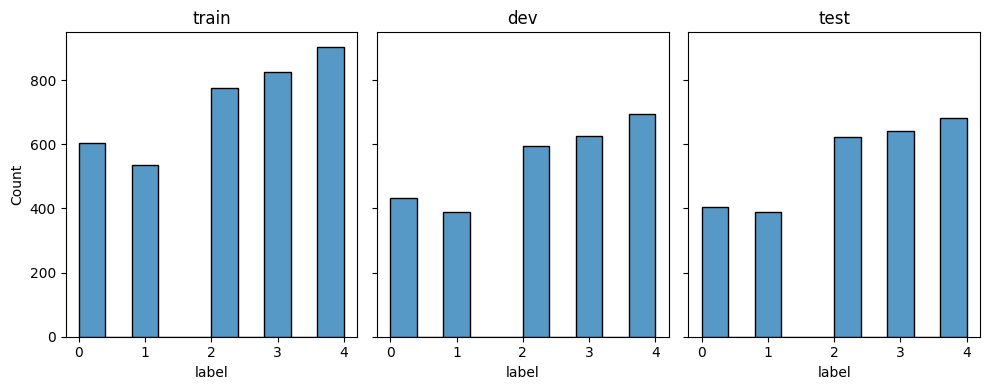

train
           index  human_score
0  (-0.001, 0.2]     0.165477
1     (0.2, 0.4]     0.147091
2     (0.4, 0.6]     0.212953
3     (0.6, 0.8]     0.226400
4     (0.8, 1.0]     0.248079
dev
           index  human_score
0  (-0.001, 0.2]     0.158202
1     (0.2, 0.4]     0.142492
2     (0.4, 0.6]     0.217391
3     (0.6, 0.8]     0.228718
4     (0.8, 1.0]     0.253197
test
           index  human_score
0  (-0.001, 0.2]     0.147295
1     (0.2, 0.4]     0.142178
2     (0.4, 0.6]     0.227339
3     (0.6, 0.8]     0.234284
4     (0.8, 1.0]     0.248904
all
           index  human_score
0  (-0.001, 0.2]     0.157837
1     (0.2, 0.4]     0.144236
2     (0.4, 0.6]     0.218603
3     (0.6, 0.8]     0.229461
4     (0.8, 1.0]     0.249863




kk-en
Len(train): 2558  |  Len(dev): 1934  |  Len(test): 1930
Train, dev, test set `human_score` distribution


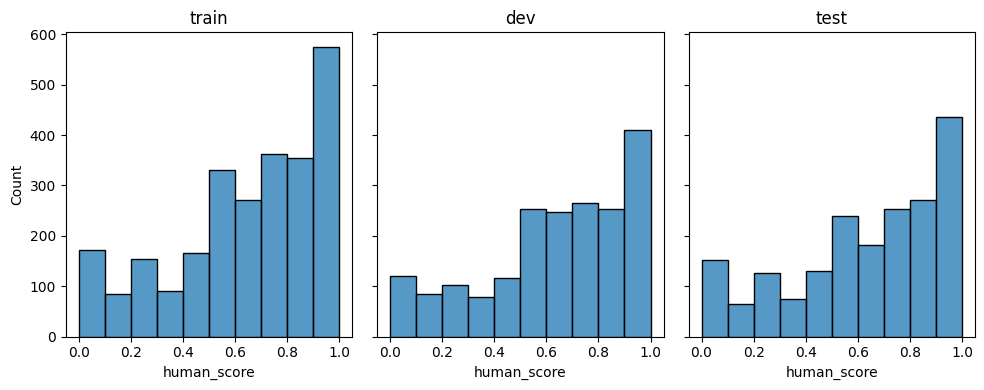

----------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
----------------------------------------------------------------------


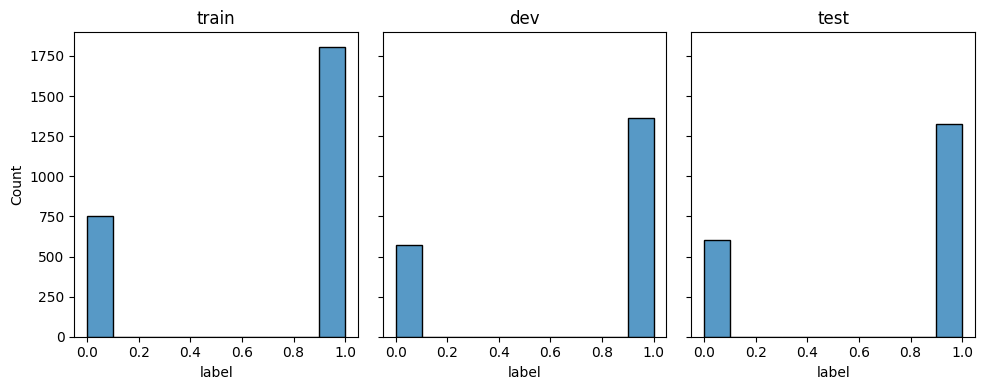

train
           index  human_score
0  (-0.001, 0.5]     0.293589
1     (0.5, 1.0]     0.706411
dev
           index  human_score
0  (-0.001, 0.5]     0.294209
1     (0.5, 1.0]     0.705791
test
           index  human_score
0  (-0.001, 0.5]     0.312953
1     (0.5, 1.0]     0.687047
all
           index  human_score
0  (-0.001, 0.5]     0.299595
1     (0.5, 1.0]     0.700405
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


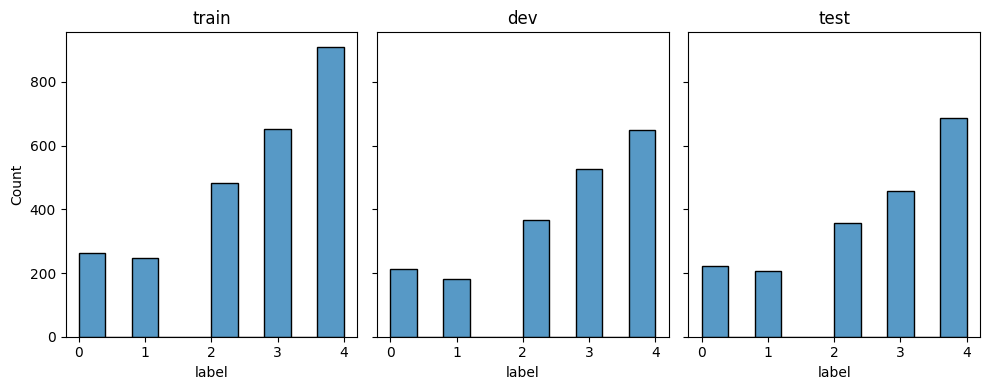

train
           index  human_score
0  (-0.001, 0.2]     0.103206
1     (0.2, 0.4]     0.096560
2     (0.4, 0.6]     0.189210
3     (0.6, 0.8]     0.255278
4     (0.8, 1.0]     0.355747
dev
           index  human_score
0  (-0.001, 0.2]     0.110134
1     (0.2, 0.4]     0.093071
2     (0.4, 0.6]     0.188728
3     (0.6, 0.8]     0.273009
4     (0.8, 1.0]     0.335057
test
           index  human_score
0  (-0.001, 0.2]     0.115544
1     (0.2, 0.4]     0.107254
2     (0.4, 0.6]     0.184456
3     (0.6, 0.8]     0.236269
4     (0.8, 1.0]     0.356477
all
           index  human_score
0  (-0.001, 0.2]     0.109000
1     (0.2, 0.4]     0.098723
2     (0.4, 0.6]     0.187636
3     (0.6, 0.8]     0.254905
4     (0.8, 1.0]     0.349735




zh-en
Len(train): 7009  |  Len(dev): 5136  |  Len(test): 5133
Train, dev, test set `human_score` distribution


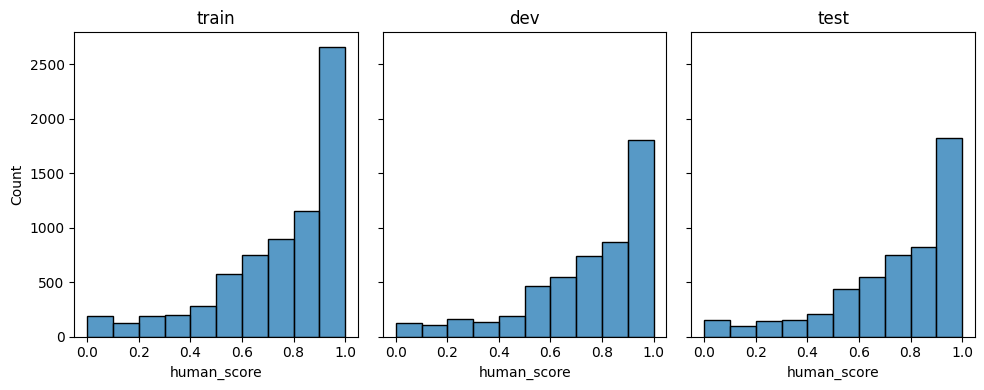

----------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
----------------------------------------------------------------------


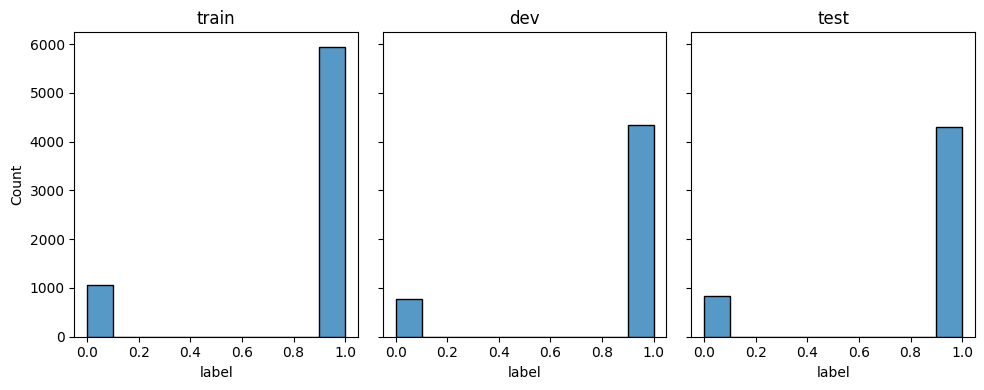

train
           index  human_score
0  (-0.001, 0.5]     0.151519
1     (0.5, 1.0]     0.848481
dev
           index  human_score
0  (-0.001, 0.5]     0.152453
1     (0.5, 1.0]     0.847547
test
           index  human_score
0  (-0.001, 0.5]     0.162088
1     (0.5, 1.0]     0.837912
all
           index  human_score
0  (-0.001, 0.5]     0.154937
1     (0.5, 1.0]     0.845063
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


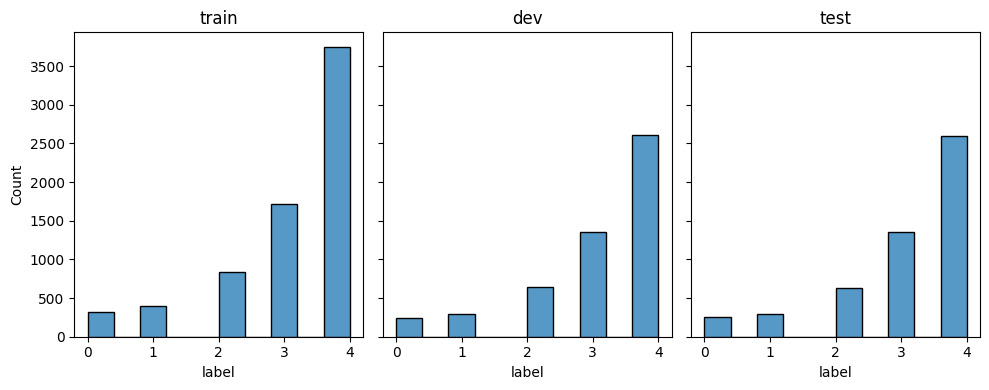

train
           index  human_score
0  (-0.001, 0.2]     0.046084
1     (0.2, 0.4]     0.055928
2     (0.4, 0.6]     0.119275
3     (0.6, 0.8]     0.243972
4     (0.8, 1.0]     0.534741
dev
           index  human_score
0  (-0.001, 0.2]     0.046145
1     (0.2, 0.4]     0.058217
2     (0.4, 0.6]     0.124611
3     (0.6, 0.8]     0.263435
4     (0.8, 1.0]     0.507593
test
           index  human_score
0  (-0.001, 0.2]     0.049873
1     (0.2, 0.4]     0.058445
2     (0.4, 0.6]     0.122540
3     (0.6, 0.8]     0.264368
4     (0.8, 1.0]     0.504773
all
           index  human_score
0  (-0.001, 0.2]     0.047228
1     (0.2, 0.4]     0.057356
2     (0.4, 0.6]     0.121831
3     (0.6, 0.8]     0.255817
4     (0.8, 1.0]     0.517768




de-en
Len(train): 12044  |  Len(dev): 9016  |  Len(test): 9090
Train, dev, test set `human_score` distribution


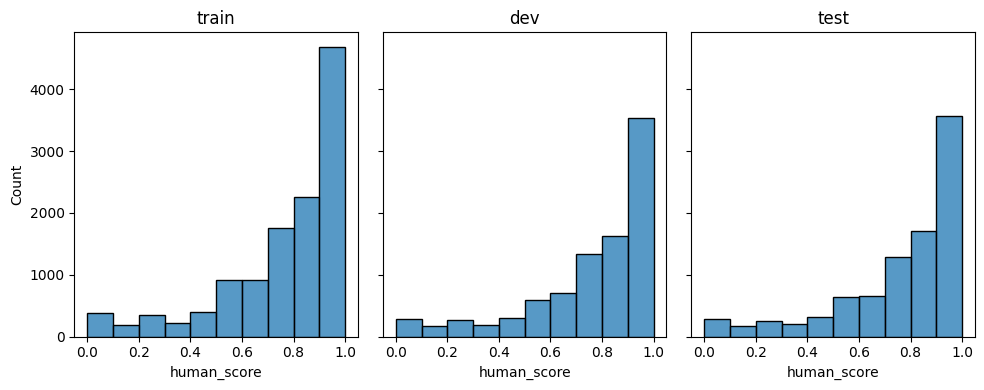

----------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
----------------------------------------------------------------------


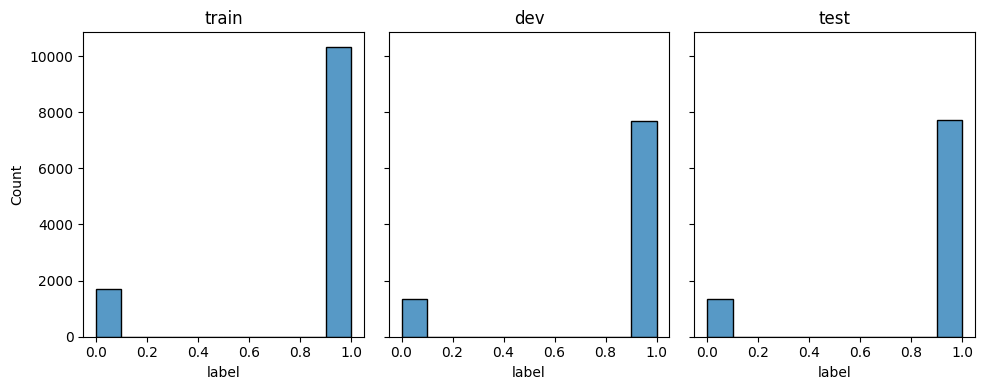

train
           index  human_score
0  (-0.001, 0.5]     0.142312
1     (0.5, 1.0]     0.857688
dev
           index  human_score
0  (-0.001, 0.5]     0.147183
1     (0.5, 1.0]     0.852817
test
           index  human_score
0  (-0.001, 0.5]     0.149505
1     (0.5, 1.0]     0.850495
all
           index  human_score
0  (-0.001, 0.5]     0.145937
1     (0.5, 1.0]     0.854063
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


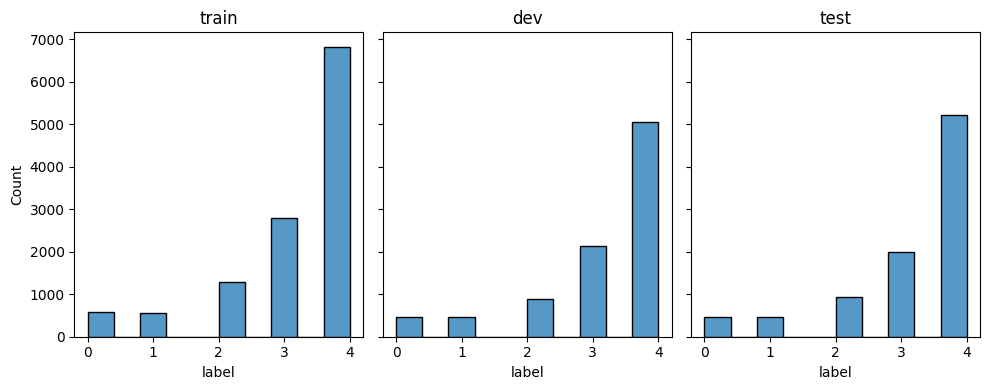

train
           index  human_score
0  (-0.001, 0.2]     0.047409
1     (0.2, 0.4]     0.046994
2     (0.4, 0.6]     0.107605
3     (0.6, 0.8]     0.231402
4     (0.8, 1.0]     0.566589
dev
           index  human_score
0  (-0.001, 0.2]     0.051797
1     (0.2, 0.4]     0.051020
2     (0.4, 0.6]     0.097826
3     (0.6, 0.8]     0.237578
4     (0.8, 1.0]     0.561779
test
           index  human_score
0  (-0.001, 0.2]     0.052255
1     (0.2, 0.4]     0.050935
2     (0.4, 0.6]     0.102420
3     (0.6, 0.8]     0.220682
4     (0.8, 1.0]     0.573707
all
           index  human_score
0  (-0.001, 0.2]     0.050182
1     (0.2, 0.4]     0.049386
2     (0.4, 0.6]     0.103118
3     (0.6, 0.8]     0.230017
4     (0.8, 1.0]     0.567297




fi-en
Len(train): 6612  |  Len(dev): 4946  |  Len(test): 5019
Train, dev, test set `human_score` distribution


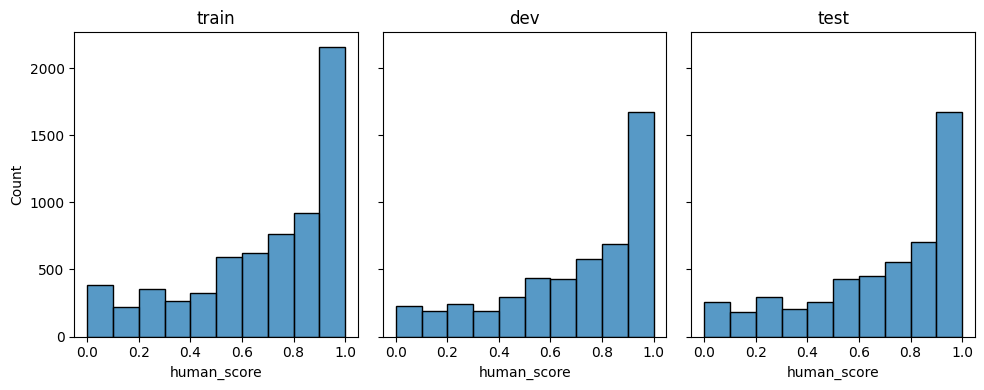

----------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
----------------------------------------------------------------------


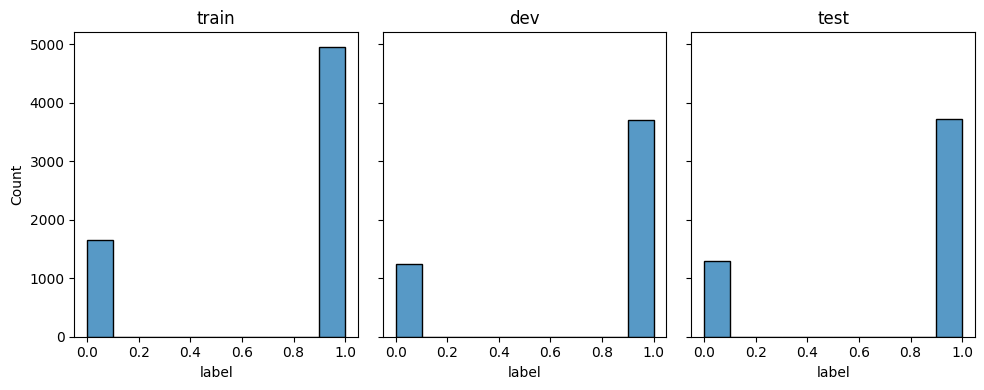

train
           index  human_score
0  (-0.001, 0.5]         0.25
1     (0.5, 1.0]         0.75
dev
           index  human_score
0  (-0.001, 0.5]     0.252123
1     (0.5, 1.0]     0.747877
test
           index  human_score
0  (-0.001, 0.5]     0.258617
1     (0.5, 1.0]     0.741383
all
           index  human_score
0  (-0.001, 0.5]     0.253242
1     (0.5, 1.0]     0.746758
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


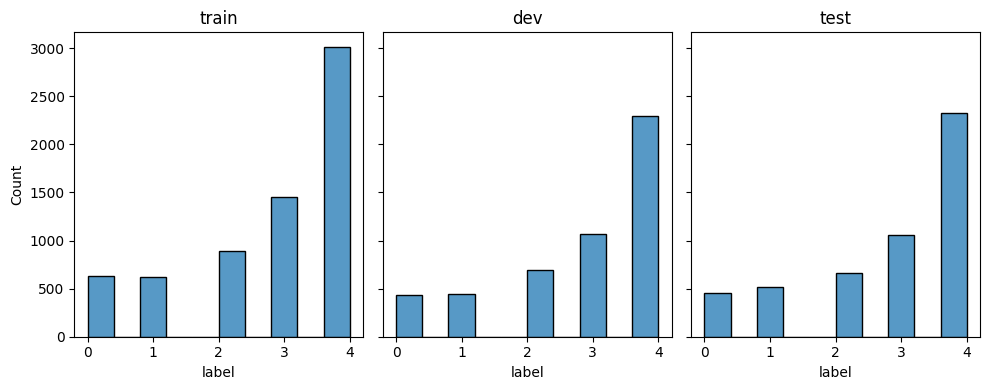

train
           index  human_score
0  (-0.001, 0.2]     0.096189
1     (0.2, 0.4]     0.093164
2     (0.4, 0.6]     0.134906
3     (0.6, 0.8]     0.219903
4     (0.8, 1.0]     0.455838
dev
           index  human_score
0  (-0.001, 0.2]     0.088152
1     (0.2, 0.4]     0.090780
2     (0.4, 0.6]     0.140922
3     (0.6, 0.8]     0.215528
4     (0.8, 1.0]     0.464618
test
           index  human_score
0  (-0.001, 0.2]     0.091452
1     (0.2, 0.4]     0.102012
2     (0.4, 0.6]     0.132098
3     (0.6, 0.8]     0.211596
4     (0.8, 1.0]     0.462841
all
           index  human_score
0  (-0.001, 0.2]     0.092357
1     (0.2, 0.4]     0.095132
2     (0.4, 0.6]     0.135851
3     (0.6, 0.8]     0.216083
4     (0.8, 1.0]     0.460578




lt-en
Len(train): 4129  |  Len(dev): 3047  |  Len(test): 3117
Train, dev, test set `human_score` distribution


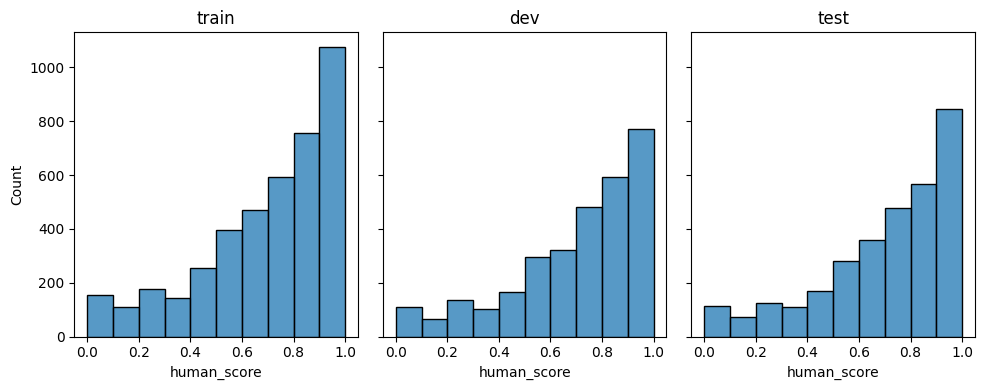

----------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
----------------------------------------------------------------------


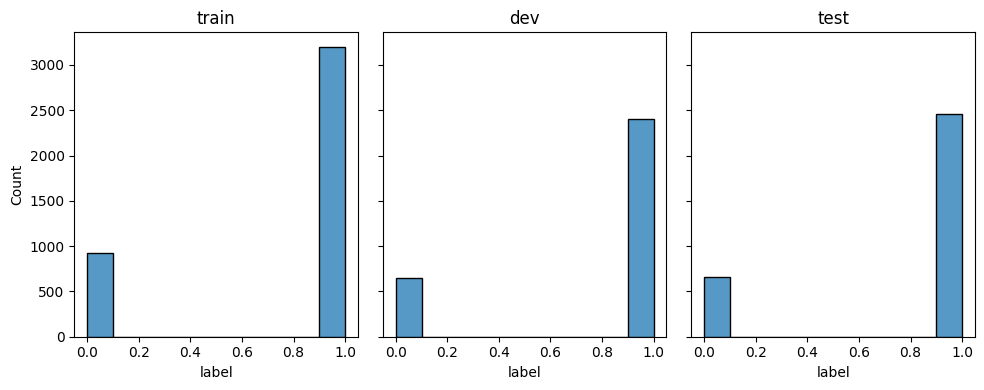

train
           index  human_score
0  (-0.001, 0.5]     0.224994
1     (0.5, 1.0]     0.775006
dev
           index  human_score
0  (-0.001, 0.5]      0.21234
1     (0.5, 1.0]      0.78766
test
           index  human_score
0  (-0.001, 0.5]     0.211421
1     (0.5, 1.0]     0.788579
all
           index  human_score
0  (-0.001, 0.5]     0.217138
1     (0.5, 1.0]     0.782862
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


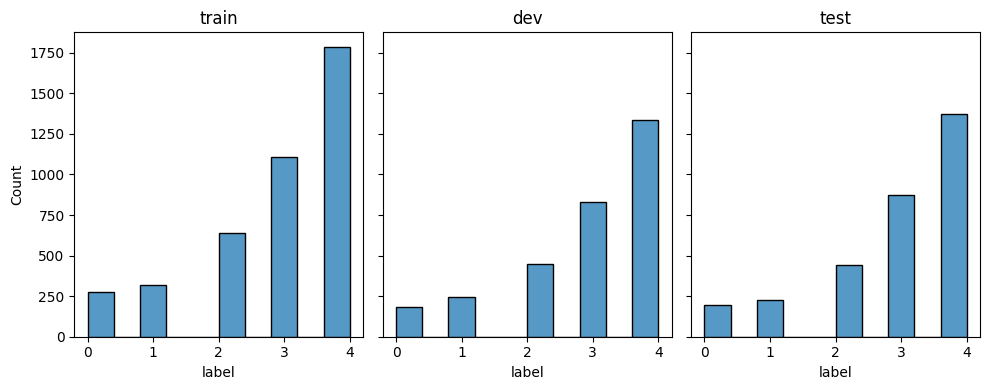

train
           index  human_score
0  (-0.001, 0.2]     0.066118
1     (0.2, 0.4]     0.077016
2     (0.4, 0.6]     0.155486
3     (0.6, 0.8]     0.268588
4     (0.8, 1.0]     0.432792
dev
           index  human_score
0  (-0.001, 0.2]     0.060059
1     (0.2, 0.4]     0.080079
2     (0.4, 0.6]     0.147686
3     (0.6, 0.8]     0.273055
4     (0.8, 1.0]     0.439120
test
           index  human_score
0  (-0.001, 0.2]     0.063202
1     (0.2, 0.4]     0.073468
2     (0.4, 0.6]     0.142445
3     (0.6, 0.8]     0.280077
4     (0.8, 1.0]     0.440808
all
           index  human_score
0  (-0.001, 0.2]     0.063441
1     (0.2, 0.4]     0.076848
2     (0.4, 0.6]     0.149228
3     (0.6, 0.8]     0.273390
4     (0.8, 1.0]     0.437093




ru-en
Len(train): 7842  |  Len(dev): 5817  |  Len(test): 5805
Train, dev, test set `human_score` distribution


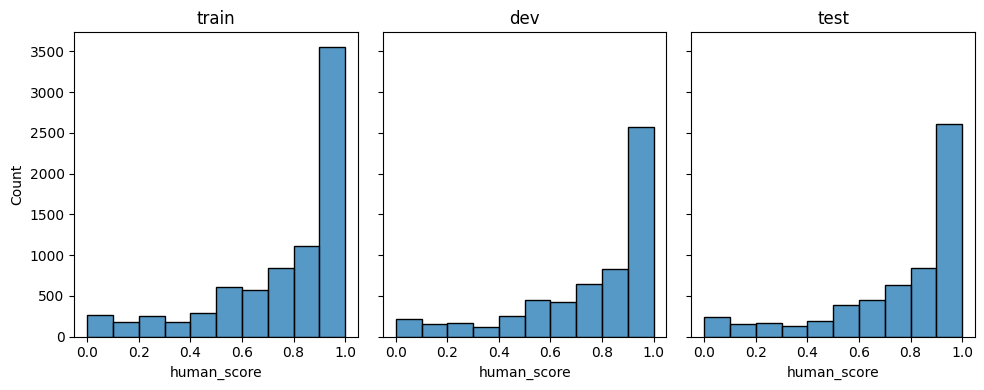

----------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
----------------------------------------------------------------------


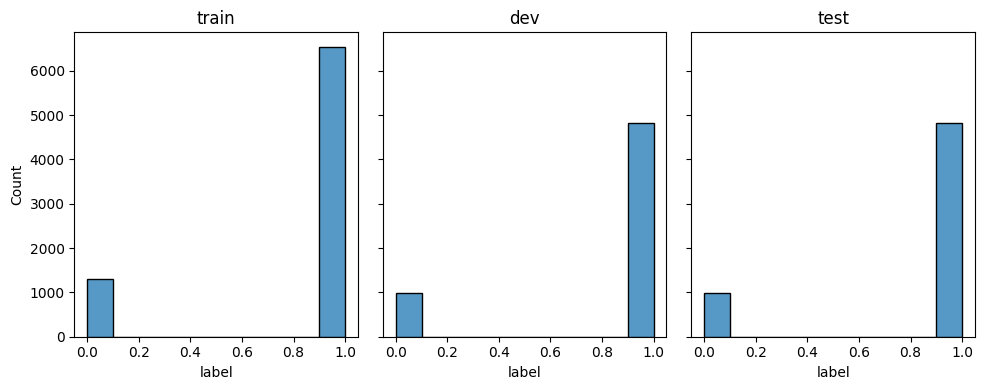

train
           index  human_score
0  (-0.001, 0.5]     0.165774
1     (0.5, 1.0]     0.834226
dev
           index  human_score
0  (-0.001, 0.5]      0.17105
1     (0.5, 1.0]      0.82895
test
           index  human_score
0  (-0.001, 0.5]     0.169337
1     (0.5, 1.0]     0.830663
all
           index  human_score
0  (-0.001, 0.5]     0.168413
1     (0.5, 1.0]     0.831587
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


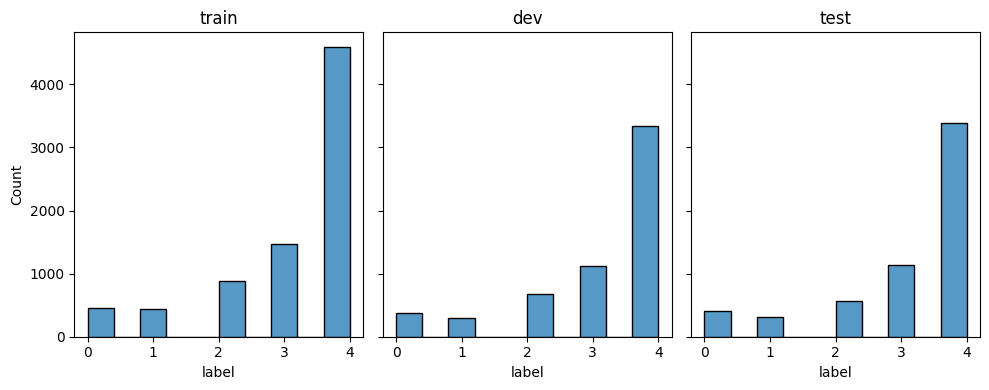

train
           index  human_score
0  (-0.001, 0.2]     0.058659
1     (0.2, 0.4]     0.055088
2     (0.4, 0.6]     0.112854
3     (0.6, 0.8]     0.187452
4     (0.8, 1.0]     0.585947
dev
           index  human_score
0  (-0.001, 0.2]     0.063779
1     (0.2, 0.4]     0.051917
2     (0.4, 0.6]     0.116039
3     (0.6, 0.8]     0.193571
4     (0.8, 1.0]     0.574695
test
           index  human_score
0  (-0.001, 0.2]     0.069595
1     (0.2, 0.4]     0.054780
2     (0.4, 0.6]     0.096296
3     (0.6, 0.8]     0.196038
4     (0.8, 1.0]     0.583290
all
           index  human_score
0  (-0.001, 0.2]     0.063450
1     (0.2, 0.4]     0.054048
2     (0.4, 0.6]     0.108868
3     (0.6, 0.8]     0.191841
4     (0.8, 1.0]     0.581792


In [12]:
for src_lang in ("gu", "kk", "zh", "de", "fi", "lt", "ru"):
    language_pair = f"{src_lang}-en"
    print_sep(language_pair)

    output_dir = f"{DIR_DATASET_PREPROC}/{language_pair}"
    os.makedirs(output_dir, exist_ok=True)

    df_darr_w_scores = pd.read_csv(f"{DIR_DATASET_PREPROC}/{language_pair}/{PREPROC_DATA_FILENAME}.csv")
    # -------------------------------------------------------------------------------
    # Step 1. Scale to [0, 1]
    # -------------------------------------------------------------------------------
    df_darr_w_scores["human_score"] = df_darr_w_scores[TARGET_COL].apply(lambda ex: round(ex/100, 4))
    assert df_darr_w_scores["human_score"].apply(lambda ex: 0 <= ex <= 1).all()

    # -------------------------------------------------------------------------------
    # Step 2. Split creation (by src)
    # -------------------------------------------------------------------------------
    src = df_darr_w_scores["src"].unique()
    src_ids = train_test_split_ids(ids=np.arange(len(src)), test_fraction=TEST_FRACTION, dev_fraction=DEV_FRACTION, seed=SEED)
    assert_non_overlapping(src_ids)
    
    dfs = [collect_src(df_darr_w_scores, src, ids) for ids in src_ids]
    dfs_names = ["train", "dev", "test"]
    print("  |  ".join([f"Len({name}): {len(df)}" for name, df in zip(dfs_names, dfs)]))

    # -------------------------------------------------------------------------------
    # Step 3. Plot distributions
    # -------------------------------------------------------------------------------
    print(f"Train, dev, test set `human_score` distribution")
    plot_distributions(data=[d["human_score"] for d in dfs], labels=dfs_names)


    # Step 3.1. Plot *binary* distribution
    print("-" * 70)
    binary_configs = {"binrange": (0, 1), "bins": 2}
    print("2-class distribution using configs:", binary_configs)
    print("-" * 70)


    dfs_class2 = [discretize_dist(d, "human_score", **binary_configs) for d in dfs]
    plot_distributions(data=[d["label"] for d in dfs_class2], labels=dfs_names)

    for d, d_name in zip(dfs_class2, dfs_names):
        if len(d) != 0:
            print(d_name)
            print(get_distribution(d["human_score"], **binary_configs))
            d.to_csv(f"{output_dir}/2class_{d_name}.csv", index=False)

    dfs_class2_all = pd.concat(dfs_class2)
    dfs_class2_all.to_csv(f"{output_dir}/2class_all.csv", index=False)
    print("all")
    print(get_distribution(dfs_class2_all["human_score"], **binary_configs))

    # Step 3.2. Plot *5-class* distribution
    print("-" * 80)
    fivary_configs = {"binrange": (0, 1), "bins": 5}
    print("5-Class distribution using configs:", fivary_configs)
    print("-" * 80)
    
    dfs_class5 = [discretize_dist(d, "human_score", **fivary_configs) for d in dfs]
    plot_distributions(data=[d["label"] for d in dfs_class5], labels=dfs_names)

    for d, d_name in zip(dfs_class5, dfs_names):
        if len(d) != 0:
            print(d_name)
            print(get_distribution(d["human_score"], **fivary_configs))
            d.to_csv(f"{output_dir}/5class_{d_name}.csv", index=False)


    dfs_class5_all = pd.concat(dfs_class5)
    dfs_class5_all.to_csv(f"{output_dir}/5class_all.csv", index=False)
    print("all")
    print(get_distribution(dfs_class5_all["human_score"], **fivary_configs))